# Diffusers实战

本章涵盖的知识点如下：
- 学习如何使用一个功能强大的自定义扩散模型管线(pipeline)，并了解如何独立制作一个新版本。
- 通过以下方式创建自己的迷你管线：
    - 复习扩散模型的核心概念
    - 从 Hugging Face Hub中加载数据以进行训练
    - 探索如何使用调度器将噪声添加到数据中
    - 创建并训练一个UNet网络模型
    - 将各个模块组合在一起，形成一个工作管线(working pipeline)
- 编写并执行一段代码，以初始化一个时间较长的训练过程，这段代码涉及以下处理环节：
    - 使用Accelerate库调用多个GPU以加快模型的训练过程
    - 记录并查阅实验日志以跟踪关键统计数据
    - 将最终模型上传到Hugging Face Hub

## 1. 环境准备

### 1.1 安装Diffusers库

首先安装包括Diffusers库在内的第三方库：

```bash
pip install diffusers datasets transformers accelerate fifty pyarrow
```

然后访问 https://huggingface.co/settings/tokens ，创建具有write权限的访问令牌

你可以通过命令行使用创建的访问令牌来登陆(huggingface-cli login)，也可以通过运行以下代码来登陆：

In [1]:
from huggingface_hub import notebook_login

notebook_login()

/Users/hongshuo/Diffusion-Model/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


接下来，你需要安装 Git LFS以上传模型检查点：(MacOS用户建议在终端中运行以下命令：)
```bash
brew install git-lfs
git lfs install
```

然后回到vscode终端后检查
```bash
git lfs --version
```

In [ ]:
'''
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store
'''

最后，导入将要使用的库并定义一些简单的支持函数：

In [2]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from matplotlib import pyplot as plt
from PIL import Image

def show_images(x):
    """
    给定一批图像,创建一个网格并将其转换为PIL
    """
    x = x*0.5+0.5 # 将(-1,1)区间映射回(0,1)区间
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1,2,0).clip(0,1) * 255
    grid_im = Image.formarray(np.array(grid_im).astype(np.unit8))
    return grid_im

def make_grid(images,size=64):
    """
    给定一个PIL图像列表,将他们叠加成一行便于查看
    """
    output_im = Image.new("RGB",(size*len(images),size))
    for i,im in enumerate(images):
        output_im.past(im.resize((size,size)),(i*size,0))
    return output_im

device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if torch.mps.is_available
                      else "cpu")

### 1.2 DreamBooth

你一定听说过稳定扩散模型(Stable Diffusion Model)，这是一个功能强大的图像生成模型，但它也有局限性：除非互联网上包含大量我们的照片，否则它无法识别你我长什么样。

然而，DreamBooth能让我们对稳定扩散模型进行微调，并在整个过程中引入特定的面部、物体或风格的额外信息。

首先让我们加载这个管线：

In [3]:
from diffusers import StableDiffusionPipeline

# https://huggingface.co/sd-dreambooth-library 中有来自社区的各种模型
model_id = "sd-dreambooth-library/mr-potato-head"
# 你可以前往 https://huggingface.co/sd-dreambooth-library/mr-potato-head 查看

# 加载管线
pipe = StableDiffusionPipeline.from_pretrained(model_id,torch_dtype=torch.float16).to(device)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

diffusion_pytorch_model.bin:   2%|1         | 31.5M/1.72G [00:00<?, ?B/s]

pytorch_model.bin:  17%|#7        | 41.9M/246M [00:00<?, ?B/s]

pytorch_model.bin:   7%|6         | 41.9M/608M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /Users/hongshuo/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/hongshuo/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /Users/hongshuo/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /Users/hongshuo/.cache/huggingface/hub/models--sd-dreambooth-library--mr-potato-head/snapshots/34246b94acd8b96166e8d93eaded001c380a2d4e/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


以上代码会自动从Hugging Face Hub下载模型权重等需要的文件。

管线加载完之后，使用以下代码即可生成示例图像：

  0%|          | 0/50 [00:00<?, ?it/s]

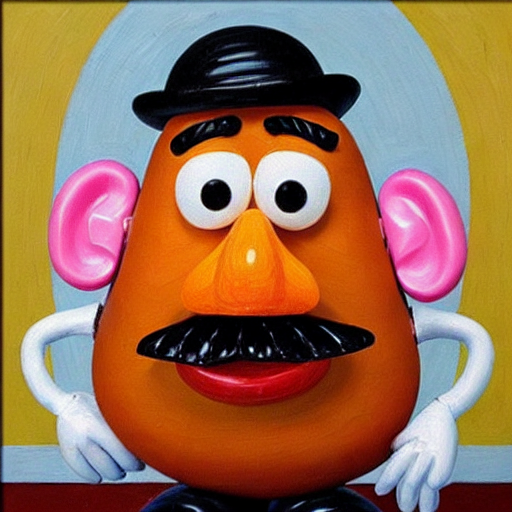

In [4]:
prompt = "an abstract oil painting of sks mr potato head by picasso"
image = pipe(prompt,num_inference_steps=50,guidance_scale=7.5).images[0]
image

**参数说明：**

- `sks`是新引入的唯一标识符(Unique IDentifier, UID)，尝试将其留空，看看会发生什么？
- `num_inference_steps`代表采样步骤的数量
- `guidance_scale`决定模型的输出与提示语之间的匹配程度

通过调整这些参数，你可以进一步探索模型的行为和性能

### 1.3 Diffusers核心API

Diffusers核心API主要分为三个部分：

- 管线：从高层次设计的多种类函数，旨在便于部署的方式实现，能够快速地利用与训练好的主流扩散模型来生成样本
- 模型：在训练新的扩散模型时需要用到的网络结构，如UNet网络模型
- 调度器：在推理过程中使用多种不同的技巧来从噪声中生成图像，同时也可以生成训练过程中所需的“带噪”图像

